In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from icecream import ic
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode, read_image

In [2]:
root_path = os.path.dirname(os.getcwd())
img_path = f"{root_path}/images"

In [3]:
CLASSES = (
    "empty",
    "black",
    "white",
)

TRAIN_PERCENTAGE = 0.8
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 4


In [4]:
label_tuples = []
for label in CLASSES:
    dir_path = f"{img_path}/{label}"
    dir_files = [
        f"{dir_path}/{f}" for f in os.listdir(f"{dir_path}") if f.endswith(".png")
    ]
    class_labels = [(file_path, CLASSES.index(label)) for file_path in dir_files]
    label_tuples += class_labels

label_tuples[0]

('/Users/roman/git/personal/goban-watcher/images/empty/8.png_0_18.png', 0)

In [5]:
sorted_labels = pd.DataFrame(label_tuples)
sorted_labels[1].value_counts()

1
0    9884
2    2731
1    1825
Name: count, dtype: int64

In [6]:
labels = sorted_labels.sample(frac=1, random_state=10).reset_index(drop=True)
labels[1].value_counts()

1
0    9884
2    2731
1    1825
Name: count, dtype: int64

### Undersample

In [7]:
column_name = sorted_labels.columns[1]

# Count the number of samples in each category
min_count = sorted_labels[column_name].value_counts().min()

# Create a list to hold the undersampled DataFrame
undersampled_df = pd.DataFrame()

# Loop through each category and sample
for label in sorted_labels[column_name].unique():
    undersampled_df = pd.concat(
        [
            undersampled_df,
            sorted_labels[sorted_labels[column_name] == label].sample(
                min_count, random_state=42
            ),
        ]
    )

labels = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
labels[1].value_counts()

1
2    1825
0    1825
1    1825
Name: count, dtype: int64

In [8]:
total_labels = labels.shape[0]
ic(total_labels)
amount_train_labels = int(total_labels * TRAIN_PERCENTAGE)


train_labels, test_labels = (
    labels[:amount_train_labels],
    labels[amount_train_labels:],
)

ic| total_labels: 5475


### Creating a Dataset

In [ ]:
class StonesDataset(Dataset):
    def __init__(self, labels: pd.DataFrame, transform=None):
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx):
        img_path, label = self.labels.iloc[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)
        if self.transform:
            image = self.transform(image)
        label = int(label)

        return image, label


transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # ! has to be here otherwise you won't be able to display them later
        # transforms.RandomCrop(),
        # transforms.ColorJitter(),
        transforms.Resize((64, 64)),  # Resize to 105x105
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
    ]
)
train_dataset = StonesDataset(train_labels, transform)
test_dataset = StonesDataset(test_labels, transform)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

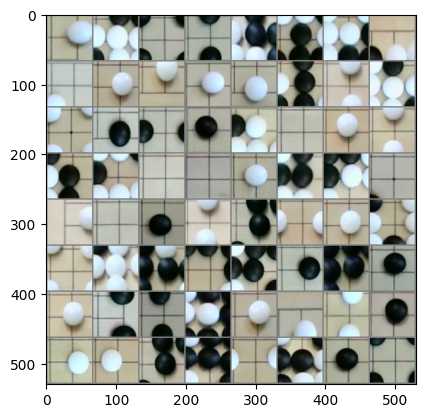

2 2 0 0 1 1 2 0 0 2 0 2 2 1 0 2 0 1 0 1 2 0 2 0 1 0 0 0 2 1 2 0 0 0 1 0 1 0 2 0 0 2 1 0 1 1 1 1 2 0 0 2 2 0 0 1 2 2 1 1 0 1 1 0


In [35]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, label_tuples = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{label_tuples[j]}" for j in range(BATCH_SIZE)))

### Neural Network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

### Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [13]:
total_batches = len(train_labels) // BATCH_SIZE
mini_batches = total_batches // 10
total_batches, mini_batches

(68, 6)

In [14]:
for epoch in range(EPOCHS):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, label_tuples = data

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, label_tuples)
        running_loss += loss
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        if i % mini_batches == 0:
            print(
                f"EPOCH: {epoch + 1}, PERCENTAGE: {i/total_batches:.2f} RUNNING LOSS: {running_loss:.4f}"
            )
            running_loss = 0
print("Finished Training")

EPOCH: 1, PERCENTAGE: 0.00 RUNNING LOSS: 1.0974
EPOCH: 1, PERCENTAGE: 0.09 RUNNING LOSS: 4.6407
EPOCH: 1, PERCENTAGE: 0.18 RUNNING LOSS: 1.7444
EPOCH: 1, PERCENTAGE: 0.26 RUNNING LOSS: 0.6454
EPOCH: 1, PERCENTAGE: 0.35 RUNNING LOSS: 0.5154
EPOCH: 1, PERCENTAGE: 0.44 RUNNING LOSS: 0.3651
EPOCH: 1, PERCENTAGE: 0.53 RUNNING LOSS: 0.3291
EPOCH: 1, PERCENTAGE: 0.62 RUNNING LOSS: 0.2269
EPOCH: 1, PERCENTAGE: 0.71 RUNNING LOSS: 0.2200
EPOCH: 1, PERCENTAGE: 0.79 RUNNING LOSS: 0.2232
EPOCH: 1, PERCENTAGE: 0.88 RUNNING LOSS: 0.3053
EPOCH: 1, PERCENTAGE: 0.97 RUNNING LOSS: 0.1059
EPOCH: 2, PERCENTAGE: 0.00 RUNNING LOSS: 0.0122
EPOCH: 2, PERCENTAGE: 0.09 RUNNING LOSS: 0.1213
EPOCH: 2, PERCENTAGE: 0.18 RUNNING LOSS: 0.2349
EPOCH: 2, PERCENTAGE: 0.26 RUNNING LOSS: 0.0911
EPOCH: 2, PERCENTAGE: 0.35 RUNNING LOSS: 0.1878
EPOCH: 2, PERCENTAGE: 0.44 RUNNING LOSS: 0.2356
EPOCH: 2, PERCENTAGE: 0.53 RUNNING LOSS: 0.2464
EPOCH: 2, PERCENTAGE: 0.62 RUNNING LOSS: 0.2634
EPOCH: 2, PERCENTAGE: 0.71 RUNNING LOSS:

### Save NN

In [18]:
PATH = "mini_stone_classification_weights.pth"
torch.save(net.state_dict(), PATH)

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [15]:
correct = 0
total = 0


with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label_tuples.size(0)
        correct += (predicted == label_tuples).sum().item()
print(
    f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f} %"
)


Accuracy of the network on the 1088 test images: 99.08 %


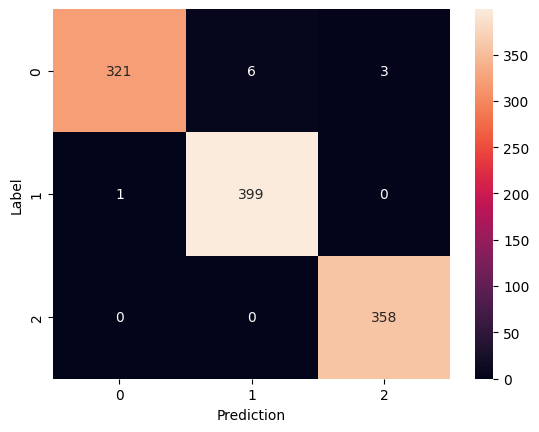

In [16]:
results = []
wrong_images = []

with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction, image in zip(label_tuples, predictions, images):
            results += [(int(label), int(prediction))]
            if prediction != label:
                wrong_images.append(image)

df = pd.DataFrame(results, columns=["Label", "Prediction"])

heatmap_data = df.pivot_table(
    index="Label", columns="Prediction", aggfunc="size", fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt="d")
plt.show()

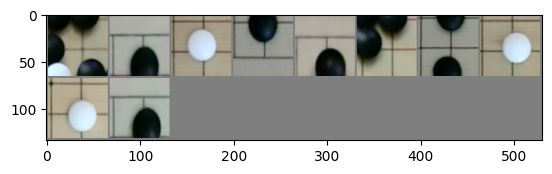

In [17]:
imshow(torchvision.utils.make_grid(wrong_images))